## Descriptive Statistics by Topology

Table structure (ICSE-style):
- **Columns:** 6 topologies (Seq FO, Par FO, Chain, Hierarchical, Probabilistic, Mesh)
- **Blocks:** Throughput (RPS), Latency (s), Energy (kJ), CPU utilization (cores)
- **Rows per block:** Mean, Min, 50%, Max, Std, CV

Data: `run_table.csv` (all sizes and repetitions aggregated per topology).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Find run_table.csv: try several locations so it works no matter where Jupyter was started
cwd = Path('.').resolve()
candidates = [
    cwd.parent / '5_results_data' / 'run_table.csv',   # Jupyter started in 5_results_analysis
    cwd / '5_results_data' / 'run_table.csv',          # Jupyter started in repo root
    cwd.parent / 'data' / 'run_table.csv',
]
RUN_TABLE_PATH = None
for p in candidates:
    try:
        if p.exists():
            RUN_TABLE_PATH = p
            break
    except Exception:
        pass
if RUN_TABLE_PATH is None:
    RUN_TABLE_PATH = candidates[0]  # use first so error message shows expected path

print("Current directory:", cwd)
print("run_table.csv path:", RUN_TABLE_PATH)
print("File exists:", RUN_TABLE_PATH.exists())
if not RUN_TABLE_PATH.exists():
    print("ERROR: run_table.csv not found. Start Jupyter from the repo folder that contains 5_results_data (e.g. topology-scale-mubench-replication or 5_results_analysis).")

Current directory: /home/irena/Documents/Research Project/topology-scale-mubench-replication/5_results_analysis
run_table.csv path: /home/irena/Documents/Research Project/topology-scale-mubench-replication/5_results_data/run_table.csv
File exists: True


In [2]:
df = pd.read_csv(RUN_TABLE_PATH)
df = df[df['__done'] == 'DONE'].copy()

# Topology short names (column order for table)
TOPOLOGY_ORDER = [
    'sequential_fanout',
    'parallel_fanout',
    'chain_with_branching',
    'hierarchical_tree',
    'probabilistic_tree',
    'complex_mesh',
]
TOPOLOGY_LABELS = {
    'sequential_fanout': 'Seq FO',
    'parallel_fanout': 'Par FO',
    'chain_with_branching': 'Chain',
    'hierarchical_tree': 'Hierarchical',
    'probabilistic_tree': 'Probabilistic',
    'complex_mesh': 'Mesh',
}

# Restrict to topologies present in data
df = df[df['topology'].isin(TOPOLOGY_ORDER)]
df['topology'] = pd.Categorical(df['topology'], categories=TOPOLOGY_ORDER, ordered=True)

# If cpu_usage_avg is fractional (e.g. 0.5 = 50%), convert to percentage for display
if 'cpu_usage_avg' in df.columns and df['cpu_usage_avg'].max() <= 1.5:
    df = df.copy()
    df['cpu_usage_avg'] = df['cpu_usage_avg'] * 100
# Derived columns for table: latency in seconds, energy in kJ (smaller numbers)
df['avg_latency_s'] = df['avg_latency_ms'] / 1000
df['energy_kj'] = df['energy'] / 1000

print("Rows:", len(df), "| Topologies:", df['topology'].nunique(), "| Sizes:", sorted(df['system_size'].unique().tolist()))

Rows: 180 | Topologies: 6 | Sizes: [5, 10, 20]


In [3]:
SIZE_ORDER = [5, 10, 20]  # system_size values (like SRV, PC, RPi in the paper)

def descriptive_block(series):
    """Mean, Min, 50%, Max, Std, CV for a series."""
    mu = series.mean()
    std = series.std()
    cv = (std / mu * 100) if mu != 0 else np.nan
    return {
        'Mean': mu,
        'Min': series.min(),
        '50%': series.median(),
        'Max': series.max(),
        'Std': std,
        'CV': cv,
    }

def build_block_df(df, metric_col, stat_order=None):
    """One block: rows = stats; columns = 6 topologies (aggregated over all sizes)."""
    if metric_col not in df.columns:
        return pd.DataFrame()
    stat_order = stat_order or ['Mean', 'Min', '50%', 'Max', 'Std', 'CV']
    by_topo = df.groupby('topology', observed=True)[metric_col].apply(
        lambda x: pd.Series(descriptive_block(x))
    ).unstack(level=1)
    by_topo = by_topo.T
    by_topo = by_topo.reindex(TOPOLOGY_ORDER, axis=1)
    by_topo.columns = [TOPOLOGY_LABELS[t] for t in by_topo.columns]
    by_topo = by_topo.reindex(stat_order)
    return by_topo

def build_block_df_by_size(df, metric_col, stat_order=None):
    """One block: rows = Mean, Min, 50%, Max, Std, CV; columns = 6 topologies × 3 sizes (18 cols).
    Like the paper: each topology has 3 sub-columns (5, 10, 20 = system_size)."""
    if metric_col not in df.columns:
        return pd.DataFrame()
    stat_order = stat_order or ['Mean', 'Min', '50%', 'Max', 'Std', 'CV']
    # grouped: index = (topology, system_size), columns = Mean, Min, 50%, Max, Std, CV
    grouped = df.groupby(['topology', 'system_size'], observed=True)[metric_col].apply(
        lambda x: pd.Series(descriptive_block(x))
    ).unstack()  # unstack stat names to columns
    out = grouped.T  # rows = stats, columns = (topology, system_size)
    # Reorder columns: (seq_fanout,5), (seq_fanout,10), (seq_fanout,20), (par_fanout,5), ...
    col_tuples = [(t, s) for t in TOPOLOGY_ORDER for s in SIZE_ORDER]
    out = out.reindex(columns=col_tuples)
    # MultiIndex columns for LaTeX: (topology_label, size)
    out.columns = pd.MultiIndex.from_tuples(
        [(TOPOLOGY_LABELS[t], s) for t, s in out.columns],
        names=['Topology', 'Size']
    )
    out = out.reindex(index=stat_order)
    return out

METRIC_BLOCKS = [
    ('throughput_rps', 'Throughput (RPS)'),
    ('avg_latency_s', 'Latency (s)'),
    ('energy_kj', 'Energy (kJ)'),
    ('cpu_usage_avg', 'CPU utilization (cores)'),
]
STAT_ORDER = ['Mean', 'Min', '50%', 'Max', 'Std', 'CV']

In [4]:
# Blocks with 3 sub-columns per topology (sizes 5, 10, 20) — like SRV, PC, RPi in the paper
blocks = {}
for col, title in METRIC_BLOCKS:
    blocks[title] = build_block_df_by_size(df, col, STAT_ORDER)

for title, tbl in blocks.items():
    print("\n" + "=" * 60)
    print("Block:", title)
    print("=" * 60)
    display(tbl.round(4))


Block: Throughput (RPS)


Topology   Seq FO                    Par FO                     Chain  \
Size           5        10      20       5        10      20       5    
Mean      22.6926  17.1512  8.5846  24.7282  17.1025  7.9086  24.6493   
Min       22.4597  17.0033  8.5570  24.2394  17.0263  7.2683  24.5298   
50%       22.7514  17.1585  8.5856  24.6706  17.1120  8.0423  24.5548   
Max       22.8817  17.2236  8.6197  25.0961  17.1567  8.2855  24.9473   
Std        0.1492   0.0624  0.0203   0.3057   0.0431  0.3704   0.1711   
CV         0.6576   0.3637  0.2366   1.2363   0.2518  4.6835   0.6940   

Topology                  Hierarchical                  Probabilistic  \
Size           10      20           5        10      20            5    
Mean      17.4236  8.7963      23.1666  17.1944  8.8190       18.2856   
Min       17.3116  8.7665      22.7906  17.1407  8.7807       17.9388   
50%       17.4399  8.7947      23.1915  17.1897  8.8209       18.2546   
Max       17.4841  8.8221      23.4240  17.2459  8.8485       18.7348   
Std        0.0550  0.0193       0.1863   0.0386  0.0219        0.2803   
CV         0.3158  0.2189       0.8041   0.2247  0.2479        1.5331   

Topology                      Mesh                  
Size           10       20      5       10      20  
Mean      23.6312  14.7228  6.3595  8.6040  8.8234  
Min       23.4507  14.6520  6.1576  8.4360  8.7895  
50%       23.5593  14.7247  6.4003  8.5969  8.8228  
Max       23.8995  14.7959  6.4996  8.8197  8.8529  
Std        0.1512   0.0401  0.1341  0.1265  0.0201  
CV         0.6398   0.2724  2.1091  1.4705  0.2283


Block: Latency (s)


Topology  Seq FO                  Par FO                    Chain          \
Size          5       10      20      5       10       20      5       10   
Mean      2.4010  3.8182  9.5625  2.0389  3.8268  10.5289  2.0510  3.7248   
Min       2.3708  3.7905  9.5278  1.9756  3.8072   9.9753  1.9939  3.7036   
50%       2.3922  3.8129  9.5652  2.0488  3.8167  10.2936  2.0672  3.7177   
Max       2.4450  3.8598  9.5894  2.1154  3.8713  11.5827  2.0766  3.7533   
Std       0.0289  0.0206  0.0245  0.0477  0.0211   0.6097  0.0313  0.0191   
CV        1.2048  0.5395  0.2562  2.3387  0.5508   5.7906  1.5259  0.5131   

Topology         Hierarchical                 Probabilistic                  \
Size          20           5       10      20            5       10      20   
Mean      9.2756       2.3119  3.8005  9.2568        3.4556  2.2255  4.7708   
Min       9.2461       2.2579  3.7723  9.2068        3.3276  2.1785  4.7323   
50%       9.2799       2.3093  3.8048  9.2560        3.4655  2.2397  4.7665   
Max       9.3116       2.3747  3.8232  9.3018        3.5593  2.2524  4.8018   
Std       0.0227       0.0332  0.0189  0.0333        0.0827  0.0290  0.0209   
CV        0.2443       1.4367  0.4967  0.3599        2.3938  1.3011  0.4376   

Topology     Mesh                  
Size           5       10      20  
Mean      13.5147  9.5154  9.2476  
Min       13.1495  9.2564  9.2107  
50%       13.4308  9.5093  9.2416  
Max       14.0049  9.7205  9.2931  
Std        0.3178  0.1605  0.0304  
CV         2.3513  1.6866  0.3285


Block: Energy (kJ)


Topology   Seq FO                     Par FO                      Chain  \
Size           5        10       20       5        10       20       5    
Mean      28.3354  37.8568  38.8916  30.4388  38.0443  36.8515  30.3984   
Min       28.0789  37.7227  38.8008  30.0823  37.9593  34.9810  30.1379   
50%       28.3499  37.8688  38.8858  30.3651  38.0368  37.3056  30.3288   
Max       28.6456  37.9506  38.9966  30.7938  38.1352  37.9112  30.7916   
Std        0.2018   0.0748   0.0562   0.2742   0.0623   1.0888   0.2179   
CV         0.7123   0.1976   0.1445   0.9007   0.1639   2.9545   0.7167   

Topology                   Hierarchical                   Probabilistic  \
Size           10       20           5        10       20            5    
Mean      38.4404  39.0783      28.8816  37.8976  39.1199       19.7358   
Min       38.3956  38.9773      28.6402  37.7916  39.0533       19.5525   
50%       38.4345  39.0889      28.9483  37.9242  39.1120       19.7116   
Max       38.4983  39.2165      29.1144  37.9574  39.1765       19.9584   
Std        0.0377   0.0700       0.1784   0.0548   0.0378        0.1074   
CV         0.0980   0.1791       0.6177   0.1446   0.0966        0.5443   

Topology                       Mesh                    
Size           10       20       5        10       20  
Mean      29.1078  38.6722  18.4216  29.8288  39.1243  
Min       28.9035  38.6230  18.2847  29.3741  39.0853  
50%       29.0452  38.6764  18.3767  29.8514  39.1284  
Max       29.4239  38.7161  18.8444  30.2788  39.1894  
Std        0.1829   0.0301   0.1581   0.3415   0.0294  
CV         0.6283   0.0779   0.8580   1.1448   0.0752


Block: CPU Utilization (%)


Topology  Seq FO                  Par FO                   Chain          \
Size          5       10      20      5       10      20      5       10   
Mean      1.7893  1.5733  0.9362  1.8744  1.6468  0.8764  1.8639  1.7164   
Min       1.7678  1.5422  0.9248  1.8526  1.6234  0.7990  1.8319  1.7011   
50%       1.7846  1.5744  0.9339  1.8717  1.6461  0.8859  1.8652  1.7151   
Max       1.8318  1.5942  0.9470  1.9075  1.6701  0.9087  1.8918  1.7307   
Std       0.0198  0.0147  0.0088  0.0167  0.0163  0.0403  0.0191  0.0087   
CV        1.1090  0.9314  0.9417  0.8888  0.9905  4.5974  1.0255  0.5085   

Topology         Hierarchical                 Probabilistic                  \
Size          20           5       10      20            5       10      20   
Mean      0.9709       1.8059  1.5717  0.9742        1.2048  1.0274  0.9130   
Min       0.9618       1.7492  1.5336  0.9572        1.1768  1.0076  0.8999   
50%       0.9696       1.8153  1.5781  0.9791        1.1999  1.0288  0.9143   
Max       0.9825       1.8340  1.5970  0.9843        1.2366  1.0364  0.9244   
Std       0.0064       0.0290  0.0237  0.0096        0.0217  0.0094  0.0083   
CV        0.6575       1.6040  1.5100  0.9809        1.8025  0.9182  0.9110   

Topology    Mesh                  
Size          5       10      20  
Mean      0.8795  1.0441  0.9727  
Min       0.8580  1.0285  0.9553  
50%       0.8789  1.0441  0.9712  
Max       0.8952  1.0601  0.9822  
Std       0.0124  0.0130  0.0087  
CV        1.4057  1.2481  0.8982

### Single combined table (all blocks stacked)

MultiIndex: (Block, Stat) x 6 topology columns.

In [5]:
combined = []
for title, tbl in blocks.items():
    tbl = tbl.copy()
    tbl.index = pd.MultiIndex.from_product([[title], tbl.index], names=['Metric', 'Stat'])
    combined.append(tbl)
table_combined = pd.concat(combined, axis=0)
table_combined

Topology                     Seq FO                           Par FO  \
Size                             5          10         20         5    
Metric              Stat                                               
Throughput (RPS)    Mean  22.692585  17.151196   8.584558  24.728206   
                    Min   22.459720  17.003273   8.556984  24.239396   
                    50%   22.751387  17.158540   8.585600  24.670647   
                    Max   22.881706  17.223611   8.619718  25.096115   
                    Std    0.149232   0.062378   0.020313   0.305717   
                    CV     0.657626   0.363693   0.236624   1.236309   
Latency (s)         Mean   2.401027   3.818177   9.562512   2.038925   
                    Min    2.370806   3.790503   9.527815   1.975641   
                    50%    2.392184   3.812888   9.565167   2.048784   
                    Max    2.445031   3.859841   9.589420   2.115364   
                    Std    0.028928   0.020601   0.024502   0.047684   
                    CV     1.204806   0.539543   0.256233   2.338695   
Energy (kJ)         Mean  28.335384  37.856808  38.891642  30.438813   
                    Min   28.078938  37.722669  38.800836  30.082349   
                    50%   28.349941  37.868757  38.885813  30.365091   
                    Max   28.645631  37.950647  38.996635  30.793776   
                    Std    0.201847   0.074815   0.056180   0.274154   
                    CV     0.712348   0.197625   0.144453   0.900671   
CPU Utilization (%) Mean   1.789262   1.573346   0.936187   1.874431   
                    Min    1.767830   1.542161   0.924846   1.852635   
                    50%    1.784580   1.574385   0.933851   1.871712   
                    Max    1.831755   1.594163   0.947018   1.907513   
                    Std    0.019844   0.014653   0.008816   0.016661   
                    CV     1.109037   0.931354   0.941736   0.888830   

Topology                                            Chain             \
Size                             10         20         5          10   
Metric              Stat                                               
Throughput (RPS)    Mean  17.102513   7.908638  24.649268  17.423599   
                    Min   17.026338   7.268329  24.529774  17.311604   
                    50%   17.112028   8.042331  24.554833  17.439934   
                    Max   17.156743   8.285495  24.947340  17.484067   
                    Std    0.043072   0.370398   0.171058   0.055020   
                    CV     0.251845   4.683461   0.693966   0.315777   
Latency (s)         Mean   3.826821  10.528907   2.050954   3.724755   
                    Min    3.807166   9.975323   1.993912   3.703628   
                    50%    3.816722  10.293603   2.067224   3.717677   
                    Max    3.871338  11.582689   2.076564   3.753254   
                    Std    0.021077   0.609685   0.031295   0.019113   
                    CV     0.550773   5.790581   1.525880   0.513133   
Energy (kJ)         Mean  38.044331  36.851509  30.398376  38.440424   
                    Min   37.959299  34.980997  30.137912  38.395599   
                    50%   38.036817  37.305556  30.328762  38.434489   
                    Max   38.135187  37.911244  30.791576  38.498329   
                    Std    0.062342   1.088771   0.217866   0.037677   
                    CV     0.163866   2.954481   0.716702   0.098014   
CPU Utilization (%) Mean   1.646778   0.876353   1.863923   1.716430   
                    Min    1.623416   0.799045   1.831865   1.701065   
                    50%    1.646055   0.885948   1.865208   1.715110   
                    Max    1.670083   0.908712   1.891822   1.730709   
                    Std    0.016311   0.040290   0.019115   0.008727   
                    CV     0.990452   4.597440   1.025548   0.508452   

Topology                            Hierarchical                        \
Size                             20 

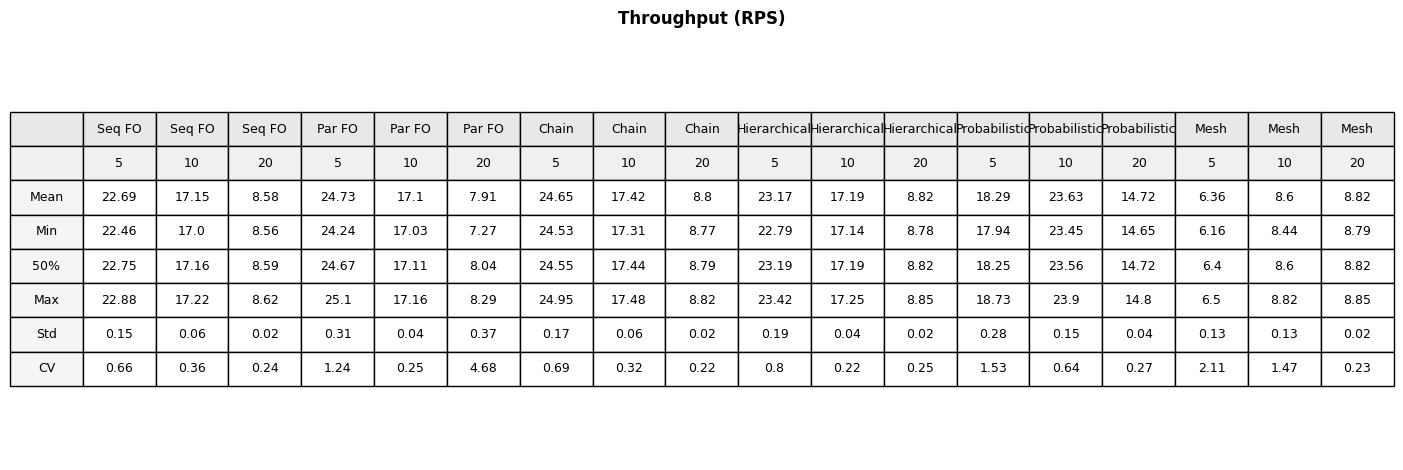

Saved: figures/descriptive_stats_Throughput_RPS.png


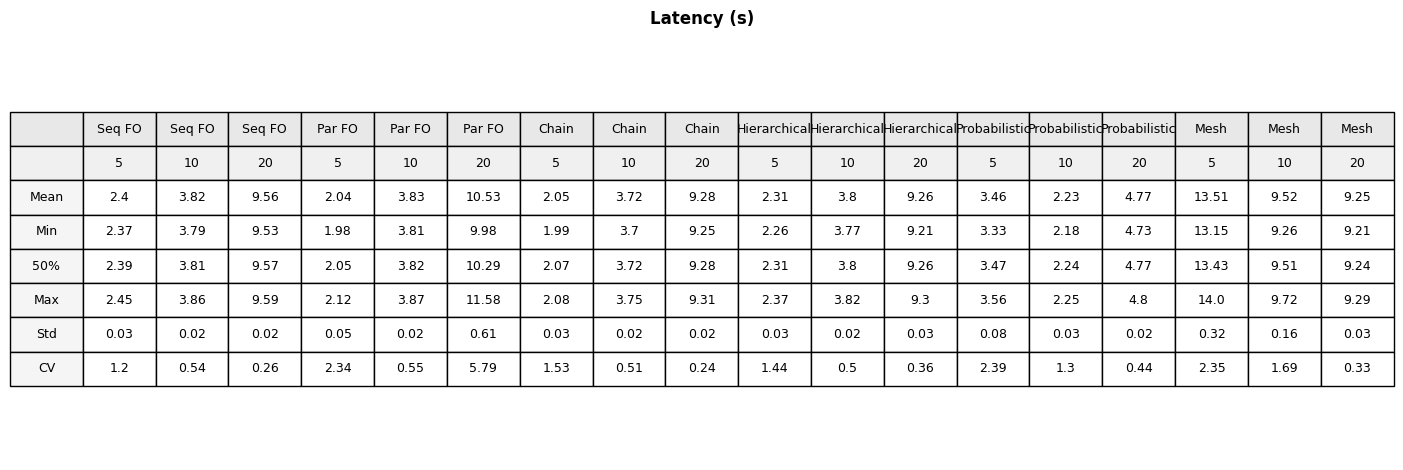

Saved: figures/descriptive_stats_Latency_s.png


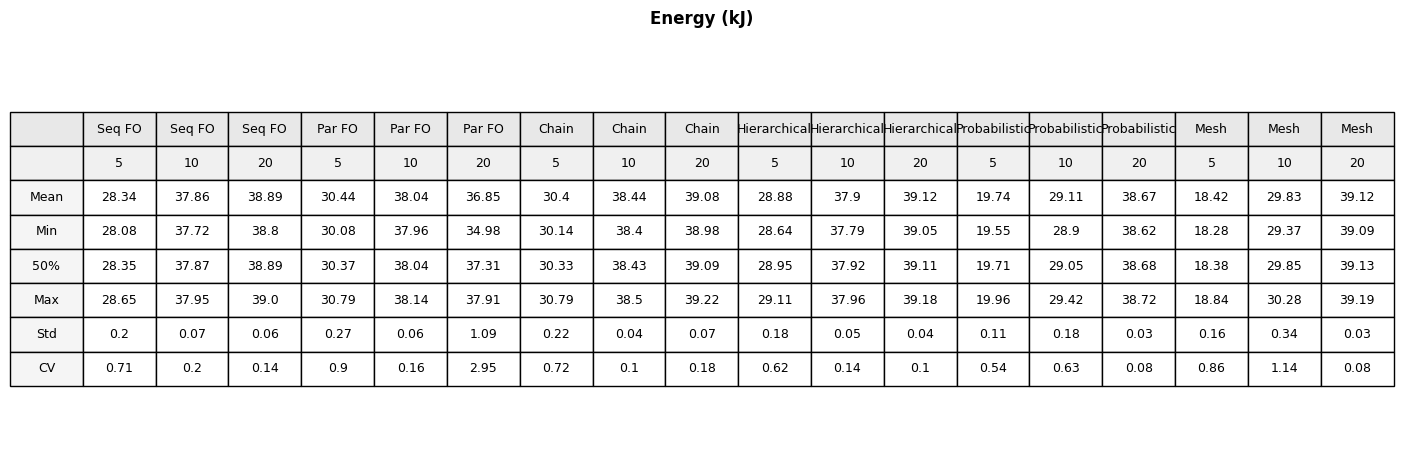

Saved: figures/descriptive_stats_Energy_kJ.png


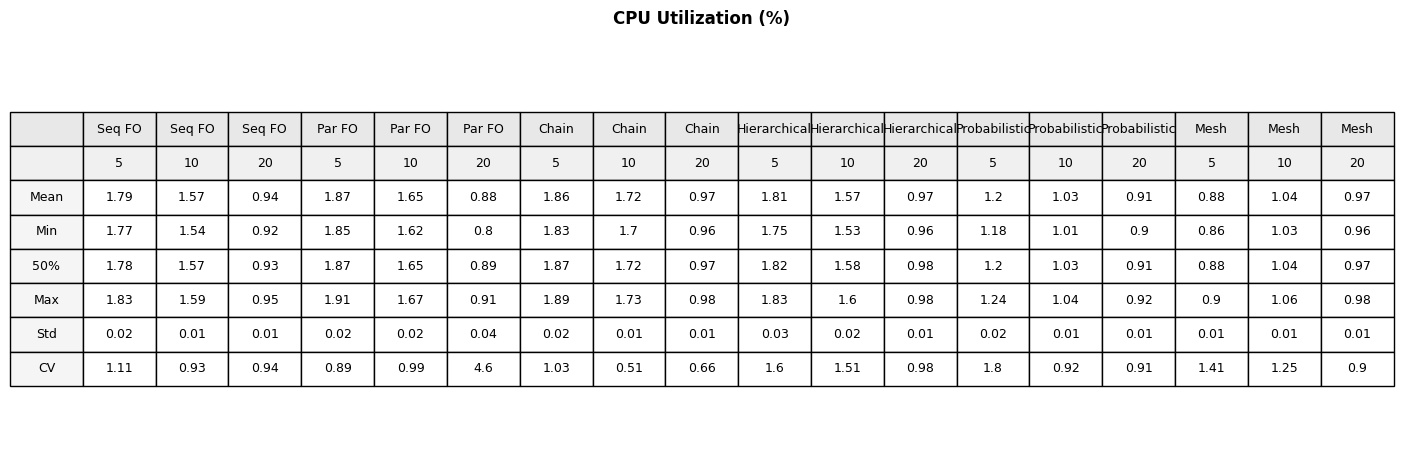

Saved: figures/descriptive_stats_CPU_Utilization_pct.png


In [6]:
# Export each block as PNG (preview before LaTeX)
import subprocess
import sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'matplotlib'])
import matplotlib.pyplot as plt

FIG_DIR = Path('figures')
FIG_DIR.mkdir(exist_ok=True)

for title, tbl in blocks.items():
    if tbl.empty:
        continue
    # Build cell text: row0 = topology labels (span 3 cols each), row1 = 5,10,20 repeated, then data rows
    n_cols = len(tbl.columns)
    cell_text = []
    # Header row 1: topology names (one per 3 columns)
    row0 = [''] + [TOPOLOGY_LABELS[t] for t in TOPOLOGY_ORDER for _ in range(len(SIZE_ORDER))]
    cell_text.append(row0)
    # Header row 2: sizes
    row1 = [''] + [str(s) for s in SIZE_ORDER] * len(TOPOLOGY_ORDER)
    cell_text.append(row1)
    # Data rows
    for stat in STAT_ORDER:
        if stat not in tbl.index:
            continue
        vals = tbl.loc[stat].round(2)
        row_strs = [str(v) if pd.notna(v) else '--' for v in vals]
        cell_text.append([stat] + row_strs)

    fig, ax = plt.subplots(figsize=(14, 2 + 0.35 * len(cell_text)))
    ax.axis('off')
    table = ax.table(cellText=cell_text, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)
    # Style header rows
    for j in range(n_cols + 1):
        table[(0, j)].set_facecolor('#e8e8e8')
        table[(1, j)].set_facecolor('#f0f0f0')
    for i in range(2, len(cell_text)):
        table[(i, 0)].set_facecolor('#f5f5f5')
    plt.title(title, fontsize=12, fontweight='bold', pad=10)
    plt.tight_layout()
    safe_name = title.replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'pct')
    png_path = FIG_DIR / f'descriptive_stats_{safe_name}.png'
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved:', png_path)

In [ ]:
# Save CSV (one file with all blocks)
OUT_DIR = Path('tables')
OUT_DIR.mkdir(exist_ok=True)
table_combined.to_csv(OUT_DIR / 'descriptive_stats_by_topology.csv')
print("Saved:", OUT_DIR / 'descriptive_stats_by_topology.csv')

Saved: tables/descriptive_stats_by_topology.csv


In [9]:
# LaTeX: final format — resizebox, vertical bars, cmidrule, multirow+rotatebox block labels, bold Mean/Min/50%/Max/Std/CV
# Only the 50% row: per size (5, 10, 20), best topology = \cellcolor{goodgreen}, worst = \cellcolor{badred}
# Requires: \usepackage{booktabs}, \usepackage{multirow}, \usepackage{graphicx}, \usepackage[table]{xcolor}
# Define in preamble: \definecolor{goodgreen}{RGB}{...}, \definecolor{badred}{RGB}{...}
n_sizes = len(SIZE_ORDER)
n_cols = len(TOPOLOGY_ORDER) * n_sizes  # 18
BLOCK_LABELS = {
    'Throughput (RPS)': r'Throughp. (rps)',
    'Latency (s)': r'Latency (s)',
    'Energy (kJ)': r'Energy (kJ)',
    'CPU utilization (cores)': r'CPU (cores)',
}
HIGHER_IS_BETTER_BLOCKS = ('Throughput (RPS)',)

latex_parts = []
latex_parts.append(r'\begin{table}[t]')
latex_parts.append(r'\caption{Descriptive statistics by topology and system size.}')
latex_parts.append(r'\label{tab:descriptive-topology}')
latex_parts.append(r'\resizebox{\textwidth}{!}{')
latex_parts.append(r'\begin{tabular}{c l|rrr|rrr|rrr|rrr|rrr|rrr}')
latex_parts.append(r'\toprule')
# Header row 1: last topology column has no trailing | ( \multicolumn{3}{c} )
header1_parts = [r'\multicolumn{3}{c|}{\small\textbf{' + TOPOLOGY_LABELS[t] + '}}' for t in TOPOLOGY_ORDER]
header1_parts[-1] = r'\multicolumn{3}{c}{\small\textbf{' + TOPOLOGY_LABELS[TOPOLOGY_ORDER[-1]] + '}}'
latex_parts.append(r'{\small } & {\small } & ' + ' & '.join(header1_parts) + r' \\')
# \cmidrule(lr){3-5} etc.
cmidrules = ' '.join([r'\cmidrule(lr){' + str(3 + i*3) + '-' + str(5 + i*3) + '}' for i in range(6)])
latex_parts.append(cmidrules)
# Header row 2: empty & empty & 5 & 10 & 20 (x6)
header2 = r'{\small } & {\small } & ' + (' & '.join([r'{\small ' + str(s) + '}' for s in SIZE_ORDER]) + ' & ') * len(TOPOLOGY_ORDER)
latex_parts.append(header2.strip().rstrip('&').strip() + r' \\')
latex_parts.append(r'\midrule')

for i, (title, tbl) in enumerate(blocks.items()):
    if i > 0:
        latex_parts.append(r'\midrule')
    label = BLOCK_LABELS.get(title, title)
    # For 50% row only: which columns are best/worst per size (5, 10, 20)
    best_cols = set()
    worst_cols = set()
    if '50%' in tbl.index:
        row_median = tbl.loc['50%']
        higher_is_better = title in HIGHER_IS_BETTER_BLOCKS
        for size_idx in range(n_sizes):
            cols_idx = [size_idx + 3 * k for k in range(len(TOPOLOGY_ORDER))]
            vals = [row_median.iloc[c] for c in cols_idx]
            if higher_is_better:
                best_idx = cols_idx[np.argmax(vals)]
                worst_idx = cols_idx[np.argmin(vals)]
            else:
                best_idx = cols_idx[np.argmin(vals)]
                worst_idx = cols_idx[np.argmax(vals)]
            best_cols.add(best_idx)
            worst_cols.add(worst_idx)
    for j, stat in enumerate(STAT_ORDER):
        if stat not in tbl.index:
            continue
        row = tbl.loc[stat].round(2)
        if stat == '50%':
            row_strs = []
            for k in range(len(row)):
                v = row.iloc[k]
                s = str(v) if pd.notna(v) else '--'
                if k in best_cols:
                    s = r'\cellcolor{goodgreen} ' + s
                elif k in worst_cols:
                    s = r'\cellcolor{badred} ' + s
                row_strs.append(s)
        else:
            row_strs = [str(v) if pd.notna(v) else '--' for v in row]
        stat_tex = r'\textbf{50\%}' if stat == '50%' else r'\textbf{' + stat + '}'
        data_part = stat_tex + ' & ' + ' & '.join(row_strs) + r' \\'
        if j == 0:
            latex_parts.append(r'\multirow{6}{*}{\rotatebox{90}{\textbf{' + label + r'}}} & ' + data_part)
        else:
            latex_parts.append(r' & ' + data_part)

latex_parts.append(r'\bottomrule')
latex_parts.append(r'\end{tabular}')
latex_parts.append(r'}')
latex_parts.append(r'\end{table}')
latex_str = '\n'.join(latex_parts)
print(latex_str)

\begin{table}[t]
\caption{Descriptive statistics by topology and system size.}
\label{tab:descriptive-topology}
\resizebox{\textwidth}{!}{
\begin{tabular}{c l|rrr|rrr|rrr|rrr|rrr|rrr}
\toprule
{\small } & {\small } & \multicolumn{3}{c|}{\small\textbf{Seq FO}} & \multicolumn{3}{c|}{\small\textbf{Par FO}} & \multicolumn{3}{c|}{\small\textbf{Chain}} & \multicolumn{3}{c|}{\small\textbf{Hierarchical}} & \multicolumn{3}{c|}{\small\textbf{Probabilistic}} & \multicolumn{3}{c}{\small\textbf{Mesh}} \\
\cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11} \cmidrule(lr){12-14} \cmidrule(lr){15-17} \cmidrule(lr){18-20}
{\small } & {\small } & {\small 5} & {\small 10} & {\small 20} & {\small 5} & {\small 10} & {\small 20} & {\small 5} & {\small 10} & {\small 20} & {\small 5} & {\small 10} & {\small 20} & {\small 5} & {\small 10} & {\small 20} & {\small 5} & {\small 10} & {\small 20} \\
\midrule
\multirow{6}{*}{\rotatebox{90}{\textbf{Throughp. (rps)}}} & \textbf{Mean} & 22.69 & 17.15 & 8.58 & 24.

In [ ]:
with open(OUT_DIR / 'descriptive_stats_by_topology.tex', 'w') as f:
    f.write(latex_str)
print("Saved:", OUT_DIR / 'descriptive_stats_by_topology.tex')

Saved: tables/descriptive_stats_by_topology.tex
